# The Battle of the Neighborhoods

## Introduction and Business Problem

### Introduction

Barcelona is due to its geographic location and culture one of Europe's best cities to live in. It has cuisines from all over the world but in this project we will search for the best place in Barcelona to open a Peruvian restaurant. While Peru is best known for ceviche, the marinated raw seafood dish, Peru's food is remarkable for the diversity of its ingredients, from wonderful fresh fish to astounding varieties of potatoes, corn and chilies. But it's still a undiscovered cuisine, and a multicultural city like Barcelona is the perfect place to show people from all over the world how amazing Peruvian food is.

### Business Problem

This report focusses on the issue of where to open a new Peruvian restaurant in Barcelona. There are many factors which can contribute in finding the perfect location but we will mainly focus on location and the proximity of other Peruvian restaurants.

## Data Acquisition and Cleaning

### Importing the required Libraries

In [1]:
import csv
import requests 
import pandas as pd 
import numpy as np
import random 
from geopy.geocoders import Nominatim
from IPython.display import Image 
from IPython.core.display import HTML 
from IPython.display import display_html
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import folium
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import io
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


### Scraping Barcelona Districts Table from Wikipedia

In [3]:
source = requests.get('https://en.wikipedia.org/wiki/Districts_of_Barcelona').text
soup = BeautifulSoup(source,'lxml')
Districts_Barcelona = soup.find('table',{'class':'wikitable'})
totals=Districts_Barcelona.find_all('tr')
nrows=len(totals)

### Extracting cells into a dataframe

In [5]:
records =[]
n=1
while n < nrows :
    District=totals[n].text.split('\n')[3]
    Size=totals[n].text.split('\n')[5]
    Population=totals[n].text.split('\n')[7]
    records.append((District,Size,Population))
    n=n+1

df=pd.DataFrame(records, columns=['District', 'Size km²', 'Population'])
df.head(11)

,District,Size km²,Population
0,Ciutat Vella,4.49,"111,290"
1,Eixample,7.46,"262,485"
2,Sants-Montjuïc,21.35,"177,636"
3,Les Corts,6.08,"82,588"
4,Sarrià-Sant Gervasi,20.09,"140,461"
5,Gràcia,4.19,"120,087"
6,Horta-Guinardó,11.96,"169,920"
7,Nou Barris,8.04,"164,981"
8,Sant Andreu,6.56,"142,598"
9,Sant Martí,10.80,"221,029"


### Calculating Latitude and Longitude per District

In [6]:
df2 = pd.read_csv('Barcelona_long_lat.csv')
df2.head(11)

,District,Latitude,Longitude
0,Ciutat Vella,41.380218,2.17319
1,Eixample,41.388960,2.16179
2,Sants-Montjuïc,41.372631,2.15460
3,Les Corts,41.383500,2.11680
4,Sarrià-Sant Gervasi,41.401039,2.13940
5,Gràcia,41.402371,2.13940
6,Horta-Guinardó,41.418491,2.16770
7,Nou Barris,41.441631,2.17727
8,Sant Andreu,41.435409,2.18982
9,Sant Martí,41.418140,2.19933


### Merging both Dataframes together

In [7]:
df3 = pd.merge(df,df2,on='District')
df3.head(12)

,District,Size km²,Population,Latitude,Longitude
0,Ciutat Vella,4.49,"111,290",41.380218,2.17319
1,Eixample,7.46,"262,485",41.388960,2.16179
2,Sants-Montjuïc,21.35,"177,636",41.372631,2.15460
3,Les Corts,6.08,"82,588",41.383500,2.11680
4,Sarrià-Sant Gervasi,20.09,"140,461",41.401039,2.13940
5,Gràcia,4.19,"120,087",41.402371,2.13940
6,Horta-Guinardó,11.96,"169,920",41.418491,2.16770
7,Nou Barris,8.04,"164,981",41.441631,2.17727
8,Sant Andreu,6.56,"142,598",41.435409,2.18982
9,Sant Martí,10.80,"221,029",41.418140,2.19933


### Search for Peruvian restaurants using Foursquare API

In [8]:
CLIENT_ID = '3JOHV5KSAHVKLY4SXXQVXQMHVKDHOVTXVLB3HVC3YGKEVLTN' # your Foursquare ID
CLIENT_SECRET = 'QJQWKWEO3BAPQ2FWZ4BYAOJ5FDQHTOJYTK2UHZW34Z21P003' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 200
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3JOHV5KSAHVKLY4SXXQVXQMHVKDHOVTXVLB3HVC3YGKEVLTN
CLIENT_SECRET:QJQWKWEO3BAPQ2FWZ4BYAOJ5FDQHTOJYTK2UHZW34Z21P003


In [9]:
latitude = 41.3851
longitude= 2.1734
search_query ='peruvian restaurant'

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&query={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            search_query,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category' ]
    
    return(nearby_venues)

### Create a new dataframe called Barcelona_venues

In [12]:
Barcelona_venues = getNearbyVenues(names=df3['District'],
                                   latitudes=df3['Latitude'],
                                   longitudes=df3['Longitude']
                                    )

Ciutat Vella
Eixample
Sants-Montjuïc
Les Corts
Sarrià-Sant Gervasi
Gràcia
Horta-Guinardó
Nou Barris
Sant Andreu
Sant Martí


In [13]:
Barcelona_venues

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ciutat Vella,41.380218,2.17319,Lascar 74,41.371930,2.165749,Peruvian Restaurant
1,Ciutat Vella,41.380218,2.17319,Mancora,41.380112,2.155734,Peruvian Restaurant
2,Ciutat Vella,41.380218,2.17319,Pakta,41.374366,2.154374,Peruvian Restaurant
3,Ciutat Vella,41.380218,2.17319,Yakumanka,41.390258,2.159950,Peruvian Restaurant
4,Ciutat Vella,41.380218,2.17319,Inka Wasi,41.381698,2.177838,Peruvian Restaurant
...,...,...,...,...,...,...,...
72,Sant Andreu,41.435409,2.18982,El Demonio De Los Andes,41.419854,2.183166,Peruvian Restaurant
73,Sant Martí,41.418140,2.19933,Kenko II,41.408231,2.180656,Peruvian Restaurant
74,Sant Martí,41.418140,2.19933,Restaurante Inka BCN,41.407377,2.184177,Peruvian Restaurant
75,Sant Martí,41.418140,2.19933,Bar-Celona,41.415551,2.177887,Peruvian Restaurant


### Count the amount of Peruvian restaurants per district

In [14]:
Barcelona_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Ciutat Vella,12,12,12,12,12,12
Eixample,20,20,20,20,20,20
Gràcia,7,7,7,7,7,7
Horta-Guinardó,6,6,6,6,6,6
Les Corts,3,3,3,3,3,3
Nou Barris,2,2,2,2,2,2
Sant Andreu,2,2,2,2,2,2
Sant Martí,4,4,4,4,4,4
Sants-Montjuïc,13,13,13,13,13,13


### Add this information into the existing Dataframe

In [15]:
df3['Number of Peruvian restaurants'] = [12, 20, 13, 3, 8, 7, 6, 2, 2, 4]
df3

,District,Size km²,Population,Latitude,Longitude,Number of Peruvian restaurants
0,Ciutat Vella,4.49,"111,290",41.380218,2.17319,12
1,Eixample,7.46,"262,485",41.388960,2.16179,20
2,Sants-Montjuïc,21.35,"177,636",41.372631,2.15460,13
3,Les Corts,6.08,"82,588",41.383500,2.11680,3
4,Sarrià-Sant Gervasi,20.09,"140,461",41.401039,2.13940,8
5,Gràcia,4.19,"120,087",41.402371,2.13940,7
6,Horta-Guinardó,11.96,"169,920",41.418491,2.16770,6
7,Nou Barris,8.04,"164,981",41.441631,2.17727,2
8,Sant Andreu,6.56,"142,598",41.435409,2.18982,2
9,Sant Martí,10.80,"221,029",41.418140,2.19933,4


### Sort the districts based on the amount of Peruvian Restaurants in that district

In [17]:
df3.set_index('District', inplace=True)
df3

,Size km²,Population,Latitude,Longitude,Number of Peruvian restaurants
District,,,,,
Ciutat Vella,4.49,"111,290",41.380218,2.17319,12
Eixample,7.46,"262,485",41.388960,2.16179,20
Sants-Montjuïc,21.35,"177,636",41.372631,2.15460,13
Les Corts,6.08,"82,588",41.383500,2.11680,3
Sarrià-Sant Gervasi,20.09,"140,461",41.401039,2.13940,8
Gràcia,4.19,"120,087",41.402371,2.13940,7
Horta-Guinardó,11.96,"169,920",41.418491,2.16770,6
Nou Barris,8.04,"164,981",41.441631,2.17727,2
Sant Andreu,6.56,"142,598",41.435409,2.18982,2


In [18]:
df3.sort_values(by='Number of Peruvian restaurants', ascending=True, inplace=True)

df4 = df3['Number of Peruvian restaurants'].tail(15)
df4

District
Nou Barris              2
Sant Andreu             2
Les Corts               3
Sant Martí              4
Horta-Guinardó          6
Gràcia                  7
Sarrià-Sant Gervasi     8
Ciutat Vella           12
Sants-Montjuïc         13
Eixample               20
Name: Number of Peruvian restaurants, dtype: int64

### Visualize The amount of Peruvian restaurants per district

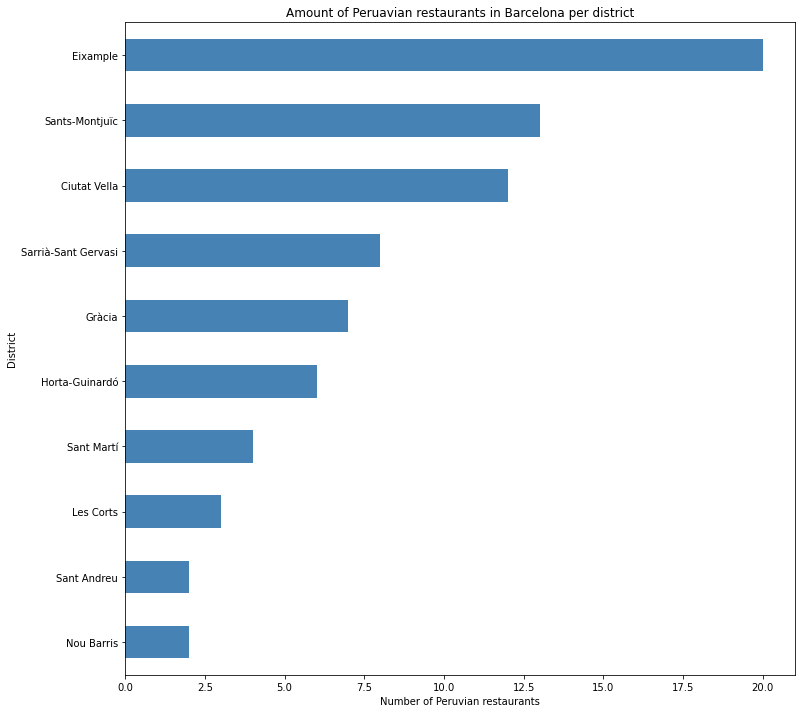

In [19]:
df4.plot(kind='barh', figsize=(12, 12),color='steelblue')
plt.xlabel('Number of Peruvian restaurants')
plt.title('Amount of Peruavian restaurants in Barcelona per district')

plt.show()

## Results

The most Peruvian restaurants are located in the Eixample district, as this make sense because it's the most central district in Barcelona. There is a big difference between the amount of Peruvian restaurants in the Eixample district and the other districts. The 3 districts with the least amount of Peruvian restaurants are Les Corts, Sant Andreu and Nou Barris. These are also the outskirts of Barcelona so it makes a lot of sense that in these districts not too many Peruvian restaurants are located.

## Discussion

Numerous factors can still influence the choice of the location where to open a Peruvian restaurant in Barcelona. For some people it can be more important to be very centrally located while others prefer to be closer to hotels or tourist attractions. Whatever the personal taste is, it´s very important to know what districts already have a lot of Peruvian restaurants and which one don't.

## Conclusion

Using Foursquare to find out the total amount of Peruvian restaurants per district helped me a lot to find the perfect place to open a new Peruvian restaurant. What noticed me the most was that the district Sant Marti, which is a very popular district and covers the entire beachside of Barcelona and has beside of Eixample the highest population, has only the 4th less amount of Peruvian restaurants in Barcelona. Due the fact this is such a popular district and Peruvian food has a great connection with the sea I would highly recommend someone opening a Peruvian restaurant in Barcelona to open it in the Sant Marti district.